In [1]:
# Импортируем библиотеки

import pandas as pd
import pandahouse as ph
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Определяем функцию для расчета p-value по t-тесту и тесту Манна-Уитни

def get_pvalues(data, groups, metric):
    # Выбираем группы
    group_control, group_test = int(groups[-2]), int(groups[-1])
     # Проводим t-тест
    p_ttest = stats.ttest_ind(df[df.exp_group == group_control][metric],
                              df[df.exp_group == group_test][metric],
                              equal_var=False)[1]
    # Проводим тест Манна-Уитни
    p_mnwtn = stats.mannwhitneyu(df[df.exp_group == group_control][metric], 
                               df[df.exp_group == group_test][metric],
                               alternative = 'two-sided')[1]
    return [p_ttest, p_mnwtn]

In [3]:
# Вытаскиваем данные из clickhouse для групп в период с 2023-01-31 по 2023-02-06
# вместе с новыми метриками

connection = {
              'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20230220',
              'user':'student', 
              'password':'dpo_python_2020'
              }

query = '''
select exp_group,
       user_id,
       sum(action='like') likes,
       sum(action='view') views,
       likes/views ctr,
       (select sum(action='like')  / sum(action='view')
        from simulator_20230220.feed_actions 
        where toDate(time) between '2023-01-31' and '2023-02-06'
              and exp_group = 0
        group by exp_group) contol_ctr,
        likes - contol_ctr * views lin_likes
from simulator_20230220.feed_actions 
where toDate(time) between '2023-01-31' and '2023-02-06'
      and exp_group in (0, 3)
group by exp_group,
       user_id
       
union all

select exp_group,
       user_id,
       sum(action='like') likes,
       sum(action='view') views,
       likes/views ctr,
       (select sum(action='like')  / sum(action='view')
        from simulator_20230220.feed_actions 
        where toDate(time) between '2023-01-31' and '2023-02-06'
              and exp_group = 1
        group by exp_group) contol_ctr,
        likes - contol_ctr * views lin_likes
from simulator_20230220.feed_actions 
where toDate(time) between '2023-01-31' and '2023-02-06'
      and exp_group in (1, 2)
group by exp_group,
       user_id
'''

df = ph.read_clickhouse(query, connection=connection)

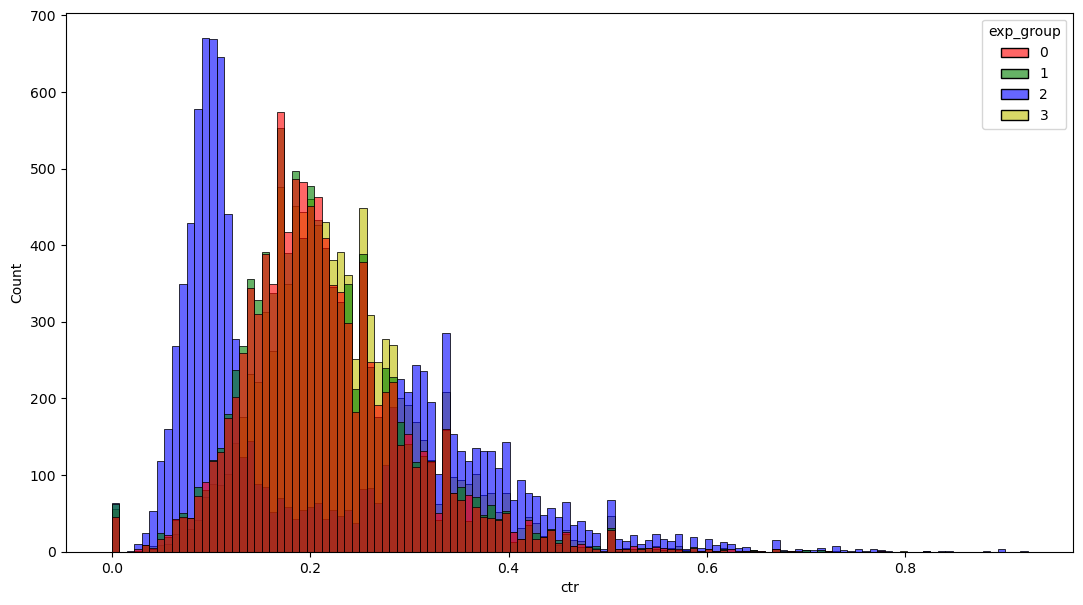

In [4]:
# Рисуем гистограмму распределения поюзерных ctr

plt.figure(figsize=(13, 7))
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'g', 'b', 'y'],
              alpha=0.6,
              kde=False)

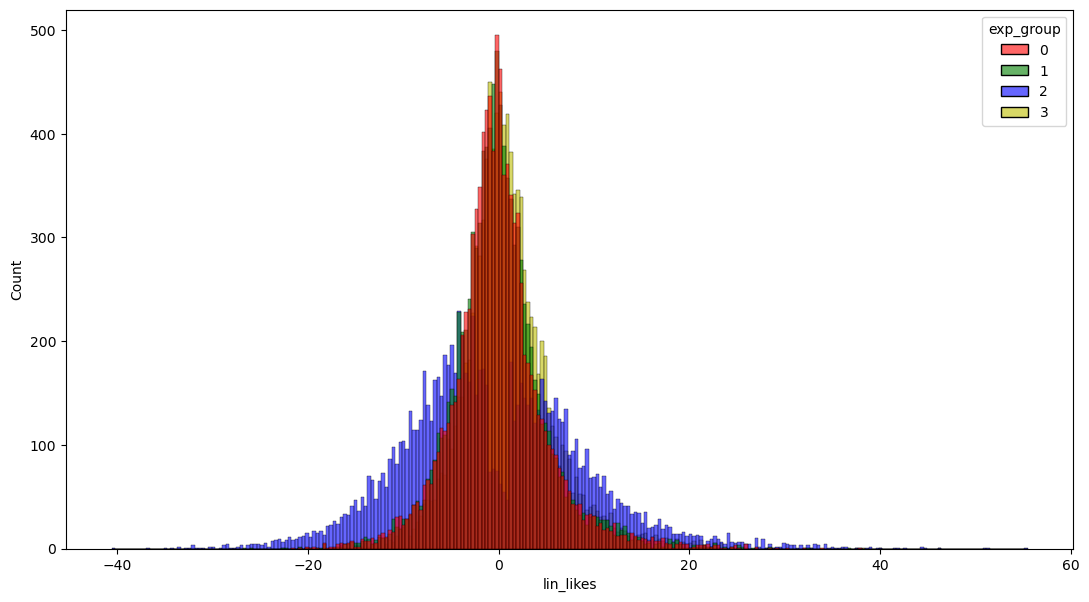

In [5]:
# Рисуем гистограмму распределения linearized likes

plt.figure(figsize=(13, 7))
groups = sns.histplot(data = df, 
              x='lin_likes', 
              hue='exp_group', 
              palette = ['r', 'g', 'b', 'y'],
              alpha=0.6,
              kde=False)

In [6]:
# Определяем словарь, в который будем вносить результаты

dict_pvalues = {0: ['ctr_by_user', 'groups_03'],
                1: ['ctr_by_user', 'groups_12'],
                2: ['linear_likes', 'groups_03'],
                3: ['linear_likes', 'groups_12']}

In [7]:
# Вносим в словарь данные по p_values

metrics = ("ctr", "ctr", "lin_likes", "lin_likes")
for i in range(4):
    dict_pvalues[i] += get_pvalues(df, dict_pvalues[i][1], metrics[i])

In [8]:
# Создаем датафрейм по p_values

df_pvalues = pd.DataFrame.from_dict(dict_pvalues, 
                                    orient='index',
                                    columns=['method', 'group', 't_test', 'manwtn'])

In [9]:
# Проводим сравнение для групп на разных методах

df_pvalues.sort_values('group')

,method,group,t_test,manwtn
0,ctr_by_user,groups_03,1.055849e-43,1.195206e-57
2,linear_likes,groups_03,5.491425e-52,1.151732e-63
1,ctr_by_user,groups_12,4.780623e-01,6.037648e-56
3,linear_likes,groups_12,9.439432e-10,9.404320e-27
